# XGBoost Model Building

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, make_scorer,
    accuracy_score, roc_auc_score, recall_score, balanced_accuracy_score,
    precision_score, f1_score, RocCurveDisplay)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [2]:
df = pd.read_csv('../data/cleaning_data_phase2.csv.zip')

### Map target variable

In [3]:
df['_michd'] = df['_michd'].apply(lambda x: 1 if x == 'Yes' else 0)

In [4]:
df['_michd'].value_counts()

0    380455
1     34056
Name: _michd, dtype: int64

### Create X and y

In [5]:
X = df.drop(columns = ['_michd', '_state'])
y = df['_michd']

### Split training and testing dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

### Preprocess numerical and categorical variables seperately

In [7]:
df_num = X.select_dtypes(include=['float', 'int'])
df_cat = X.select_dtypes(include = ['O'])

In [8]:
num_transform = 'passthrough'

cat_transform = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    # ('scaler', StandardScaler(with_mean = False, with_std = False))
])

preprocessor = ColumnTransformer(transformers = [
    ('num', num_transform, df_num.columns),
    ('cat', cat_transform, df_cat.columns)
])

In [9]:
pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    # ('sampling', SMOTE(random_state = 42)),
    ('model', xgb.XGBClassifier(random_state = 42, scale_pos_weight = float(np.sum(y_train == 0)) / np.sum(y_train == 1)))
])

In [10]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', 'passthrough',
                                    Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
          '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
          'potada1_', 'vegeda2_'],
         dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    Index(['_sex', 'genhlth', 'addepev3', 'checkup1', '_totinda', '_rfhype6',
          'cholmed3', '_rfchol3', 'cvdstrk3', '_asthms1', 'chcscncr', 'chcocncr',
          'chccopd3', 'chckdny2', 'diabete4', '_drdxar3', 'marital', '_incomg1',
          'employ1', 'decide', 'diffwalk', 'diffdres', '_smoker3', 'usenow3',
          'ecignow1', '_metstat', '_imprace', '_educag'],
         dtype='object'))])),
  ('model

In [11]:
params = {
    'model__learning_rate': [0.01, 0.1, 0.2]
}

In [12]:
gs = GridSearchCV(pipe, param_grid=params, cv = 3, scoring='balanced_accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'...
                                                      learning_rate=None,
                                                      max_bin=None,
                             

In [13]:
y_pred = gs.predict(X_test)

In [14]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.8063444929364149, 0.7867222661317972)

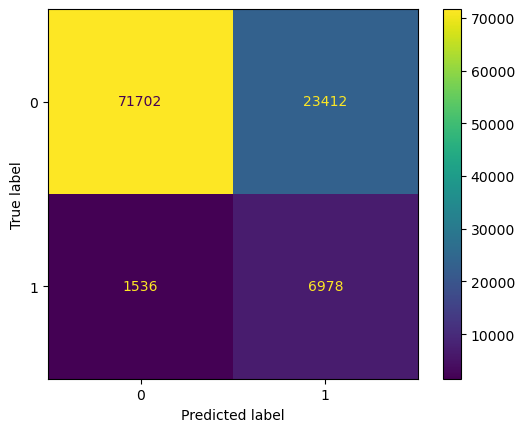

In [15]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

In [16]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label = 1)
    prec = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [17]:
scores = []

balanced_accuracy: 0.7867222661317972
recall: 0.8195912614517266
precision: 0.22961500493583414
f1 score: 0.3587291795188155


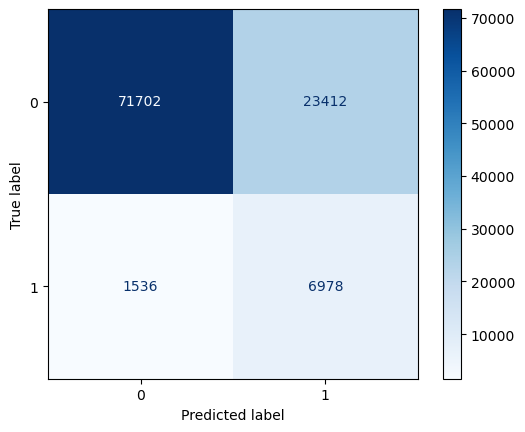

In [18]:
scores.append(evaluation(X_test, y_test, y_pred, gs))

In [22]:
evaluations = pd.DataFrame(scores, index = ['xgboost'])

evaluations.to_csv('../data/scores_XGBoost.csv')

In [23]:
evaluations

,balanced_accuracy,recall,precision,f1_score
xgboost,0.786722,0.819591,0.229615,0.358729


It looks like the XGBoost have a good balanced accuracy and recall. We will research this method in the future.